In [155]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [156]:
# Create Tensors to hold input and outputs.

#第三组参数
beta_1=np.append(np.array([4,4,-8,-4,6,-4,8,4,-6,-8]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,2,-4,-2,-3,4]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,3,-6,-3,4.5,6]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0
prior=2

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0
prior=2

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [157]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


In [158]:
sigmoid(x1@beta_1).squeeze().cov()
sigmoid(x2@beta_2).squeeze().cov()
sigmoid(x3@beta_3).squeeze().cov()

tensor(0.2250, dtype=torch.float64)

tensor(0.2174, dtype=torch.float64)

tensor(0.2192, dtype=torch.float64)

In [159]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [160]:
################## first step##################

# choose lambda1,lambda2 by ray tune

prior=2
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2,lr,ga= config["lambda1"], config["lambda2"],config["lr"],config["ga"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear23_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lr":tune.choice([0.7,0.8,0.9]),
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "ga":tune.choice([0.4,0.5,0.6])
    }
    result = tune.run(
        train_model,  
        config=config,
        num_samples=96)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,ga,lambda1,lambda2,lr,iter,total time (s),my_test_BCE_loss
train_model_19ad4_00000,TERMINATED,10.224.0.12:10758,0.4,0.05,0.001,0.9,1,12.0648,1.11436
train_model_19ad4_00001,TERMINATED,10.224.0.12:11516,0.5,0.03,0.002,0.9,1,11.8213,1.43411
train_model_19ad4_00002,TERMINATED,10.224.0.12:11519,0.4,0.05,0.002,0.9,1,11.6998,1.05017
train_model_19ad4_00003,TERMINATED,10.224.0.12:11521,0.5,0.05,0.003,0.9,1,12.0342,0.979648
train_model_19ad4_00004,TERMINATED,10.224.0.12:11522,0.5,0.03,0.001,0.9,1,11.6569,1.54208
train_model_19ad4_00005,TERMINATED,10.224.0.12:11524,0.4,0.03,0.003,0.7,1,11.8492,1.58726
train_model_19ad4_00006,TERMINATED,10.224.0.12:11526,0.6,0.03,0.001,0.8,1,11.4091,1.58055
train_model_19ad4_00007,TERMINATED,10.224.0.12:11528,0.4,0.05,0.002,0.9,1,11.7088,1.05017
train_model_19ad4_00008,TERMINATED,10.224.0.12:11530,0.4,0.04,0.001,0.8,1,11.5596,1.39209
train_model_19ad4_00009,TERMINATED,10.224.0.12:11532,0.4,0.05,0.001,0.7,1,11.5528,1.24845


Result for train_model_19ad4_00000:
  date: 2022-10-20_14-47-58
  done: false
  experiment_id: ca383f0603db49e89cad38ff9ca4bee6
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1143564462661744
  node_ip: 10.224.0.12
  pid: 10758
  time_since_restore: 12.064823627471924
  time_this_iter_s: 12.064823627471924
  time_total_s: 12.064823627471924
  timestamp: 1666248478
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 19ad4_00000
  warmup_time: 0.003774881362915039
  
Result for train_model_19ad4_00000:
  date: 2022-10-20_14-47-58
  done: true
  experiment_id: ca383f0603db49e89cad38ff9ca4bee6
  experiment_tag: 0_ga=0.4000,lambda1=0.0500,lambda2=0.0010,lr=0.9000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1143564462661744
  node_ip: 10.224.0.12
  pid: 10758
  time_since_restore: 12.064823627471924
  time_this_iter_s: 12.064823627471924
  time_total_s: 12.064823627471924
  timestamp: 1666248478
  times

Result for train_model_19ad4_00018:
  date: 2022-10-20_14-48-02
  done: false
  experiment_id: 3058cf74ef0b4a7b91b7e2defc07c686
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5805477619171142
  node_ip: 10.224.0.12
  pid: 11550
  time_since_restore: 11.502228260040283
  time_this_iter_s: 11.502228260040283
  time_total_s: 11.502228260040283
  timestamp: 1666248482
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 19ad4_00018
  warmup_time: 0.007650136947631836
  
Result for train_model_19ad4_00018:
  date: 2022-10-20_14-48-02
  done: true
  experiment_id: 3058cf74ef0b4a7b91b7e2defc07c686
  experiment_tag: 18_ga=0.6000,lambda1=0.0300,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5805477619171142
  node_ip: 10.224.0.12
  pid: 11550
  time_since_restore: 11.502228260040283
  time_this_iter_s: 11.502228260040283
  time_total_s: 11.502228260040283
  timestamp: 1666248482
  time

Result for train_model_19ad4_00029:
  date: 2022-10-20_14-48-03
  done: false
  experiment_id: 82b7240f4319445fbfededeee4901701
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 0.9987338304519653
  node_ip: 10.224.0.12
  pid: 11572
  time_since_restore: 11.90459132194519
  time_this_iter_s: 11.90459132194519
  time_total_s: 11.90459132194519
  timestamp: 1666248483
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 19ad4_00029
  warmup_time: 0.012516498565673828
  
Result for train_model_19ad4_00020:
  date: 2022-10-20_14-48-03
  done: false
  experiment_id: 3024b8bc865e476fad84bd07f626574c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.1275341987609864
  node_ip: 10.224.0.12
  pid: 11555
  time_since_restore: 12.229250431060791
  time_this_iter_s: 12.229250431060791
  time_total_s: 12.229250431060791
  timestamp: 1666248483
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 19ad4_00020
  

Result for train_model_19ad4_00028:
  date: 2022-10-20_14-48-04
  done: false
  experiment_id: 3ed3a8ed62794ff6bc6ee2efdf0b4218
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.137997329235077
  node_ip: 10.224.0.12
  pid: 11570
  time_since_restore: 13.010646104812622
  time_this_iter_s: 13.010646104812622
  time_total_s: 13.010646104812622
  timestamp: 1666248484
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 19ad4_00028
  warmup_time: 0.006103038787841797
  
Result for train_model_19ad4_00028:
  date: 2022-10-20_14-48-04
  done: true
  experiment_id: 3ed3a8ed62794ff6bc6ee2efdf0b4218
  experiment_tag: 28_ga=0.6000,lambda1=0.0400,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.137997329235077
  node_ip: 10.224.0.12
  pid: 11570
  time_since_restore: 13.010646104812622
  time_this_iter_s: 13.010646104812622
  time_total_s: 13.010646104812622
  timestamp: 1666248484
  timest

Result for train_model_19ad4_00040:
  date: 2022-10-20_14-48-14
  done: false
  experiment_id: d1473617a56e42f3b7c9e12537fcc15e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5145978450775146
  node_ip: 10.224.0.12
  pid: 11552
  time_since_restore: 12.10157060623169
  time_this_iter_s: 12.10157060623169
  time_total_s: 12.10157060623169
  timestamp: 1666248494
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 19ad4_00040
  warmup_time: 0.011650800704956055
  
Result for train_model_19ad4_00040:
  date: 2022-10-20_14-48-14
  done: true
  experiment_id: d1473617a56e42f3b7c9e12537fcc15e
  experiment_tag: 40_ga=0.5000,lambda1=0.0400,lambda2=0.0010,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5145978450775146
  node_ip: 10.224.0.12
  pid: 11552
  time_since_restore: 12.10157060623169
  time_this_iter_s: 12.10157060623169
  time_total_s: 12.10157060623169
  timestamp: 1666248494
  timesteps_

Result for train_model_19ad4_00055:
  date: 2022-10-20_14-48-15
  done: true
  experiment_id: 59141f2c9e6f47d099e541123500dd25
  experiment_tag: 55_ga=0.4000,lambda1=0.0300,lambda2=0.0010,lr=0.9000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7069473266601562
  node_ip: 10.224.0.12
  pid: 11560
  time_since_restore: 12.027248859405518
  time_this_iter_s: 12.027248859405518
  time_total_s: 12.027248859405518
  timestamp: 1666248495
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 19ad4_00055
  warmup_time: 0.012970685958862305
  
Result for train_model_19ad4_00050:
  date: 2022-10-20_14-48-15
  done: true
  experiment_id: 8fbe99ff3baf43c9820ab76e49192415
  experiment_tag: 50_ga=0.4000,lambda1=0.0400,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5156497955322266
  node_ip: 10.224.0.12
  pid: 11564
  time_since_restore: 12.2558913230896
  time_this_iter_s: 12.2558913230896

Result for train_model_19ad4_00059:
  date: 2022-10-20_14-48-15
  done: true
  experiment_id: 9157b53070344a188973306fbe5c55ba
  experiment_tag: 59_ga=0.4000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6581927299499513
  node_ip: 10.224.0.12
  pid: 11540
  time_since_restore: 12.208986282348633
  time_this_iter_s: 12.208986282348633
  time_total_s: 12.208986282348633
  timestamp: 1666248495
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 19ad4_00059
  warmup_time: 0.009269952774047852
  
Result for train_model_19ad4_00056:
  date: 2022-10-20_14-48-15
  done: false
  experiment_id: 3024b8bc865e476fad84bd07f626574c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.181455945968628
  node_ip: 10.224.0.12
  pid: 11555
  time_since_restore: 12.796163558959961
  time_this_iter_s: 12.796163558959961
  time_total_s: 12.796163558959961
  timestamp: 1666248495
  times

Result for train_model_19ad4_00068:
  date: 2022-10-20_14-48-25
  done: false
  experiment_id: da0922d5f0bd4cc88c205c84bc6cd27f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.349780762195587
  node_ip: 10.224.0.12
  pid: 11522
  time_since_restore: 11.571006298065186
  time_this_iter_s: 11.571006298065186
  time_total_s: 11.571006298065186
  timestamp: 1666248505
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 19ad4_00068
  warmup_time: 0.007754325866699219
  
Result for train_model_19ad4_00068:
  date: 2022-10-20_14-48-25
  done: true
  experiment_id: da0922d5f0bd4cc88c205c84bc6cd27f
  experiment_tag: 68_ga=0.5000,lambda1=0.0400,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.349780762195587
  node_ip: 10.224.0.12
  pid: 11522
  time_since_restore: 11.571006298065186
  time_this_iter_s: 11.571006298065186
  time_total_s: 11.571006298065186
  timestamp: 1666248505
  timest

Result for train_model_19ad4_00074:
  date: 2022-10-20_14-48-26
  done: false
  experiment_id: 3058cf74ef0b4a7b91b7e2defc07c686
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5772845029830933
  node_ip: 10.224.0.12
  pid: 11550
  time_since_restore: 11.977799415588379
  time_this_iter_s: 11.977799415588379
  time_total_s: 11.977799415588379
  timestamp: 1666248506
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 19ad4_00074
  warmup_time: 0.007650136947631836
  
Result for train_model_19ad4_00074:
  date: 2022-10-20_14-48-26
  done: true
  experiment_id: 3058cf74ef0b4a7b91b7e2defc07c686
  experiment_tag: 74_ga=0.5000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5772845029830933
  node_ip: 10.224.0.12
  pid: 11550
  time_since_restore: 11.977799415588379
  time_this_iter_s: 11.977799415588379
  time_total_s: 11.977799415588379
  timestamp: 1666248506
  time

Result for train_model_19ad4_00089:
  date: 2022-10-20_14-48-27
  done: false
  experiment_id: bed287853a794b11ba17c4a5549d3b97
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3249695777893067
  node_ip: 10.224.0.12
  pid: 11542
  time_since_restore: 11.541014671325684
  time_this_iter_s: 11.541014671325684
  time_total_s: 11.541014671325684
  timestamp: 1666248507
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 19ad4_00089
  warmup_time: 0.005298137664794922
  
Result for train_model_19ad4_00089:
  date: 2022-10-20_14-48-27
  done: true
  experiment_id: bed287853a794b11ba17c4a5549d3b97
  experiment_tag: 89_ga=0.4000,lambda1=0.0400,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3249695777893067
  node_ip: 10.224.0.12
  pid: 11542
  time_since_restore: 11.541014671325684
  time_this_iter_s: 11.541014671325684
  time_total_s: 11.541014671325684
  timestamp: 1666248507
  time

2022-10-20 14:48:28,434	INFO tune.py:758 -- Total run time: 44.23 seconds (44.00 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
19ad4_00000          1.114356         12.064824  True            None   
19ad4_00001          1.434113         11.821313  True            None   
19ad4_00002          1.050173         11.699824  True            None   
19ad4_00003          0.979648         12.034234  True            None   
19ad4_00004          1.542075         11.656900  True            None   
...                       ...               ...   ...             ...   
19ad4_00091          1.186948         11.318048  True            None   
19ad4_00092          0.949583         11.204495  True            None   
19ad4_00093          1.114356         11.196886  True            None   
19ad4_00094          1.299258         11.159396  True            None   
19ad4_00095          1.005108         10.841506  True            N

In [161]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 0.933344304561615


{'lr': 0.9, 'lambda1': 0.05, 'lambda2': 0.003, 'ga': 0.6}

In [162]:
################## second step##################

prior=2
#0.4,0.4
# set hyperparamters
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
# lambda1,lambda2,lr=final_lambda["lambda1"],final_lambda["lambda2"],final_lambda["lr"]
lambda1,lambda2,lr,ga=final_lambda["lambda1"],final_lambda["lambda2"],final_lambda["lr"],final_lambda["ga"]
learning_rate=lr
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear23_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.2404, grad_fn=<AddBackward0>)

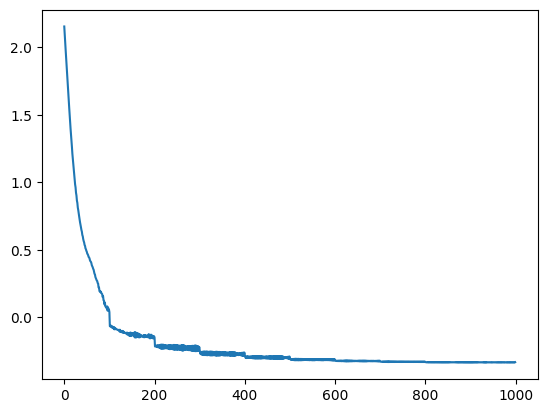

In [163]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [164]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.2959e+00, -1.2012e+00, -3.3297e-01, -1.8763e-01, -3.2067e-01,
         -1.7707e-01, -3.3195e-01, -1.7645e-01, -2.2584e-01,  3.4828e-01,
          1.6226e-04, -9.4876e-04,  1.2565e-04,  4.7213e-04,  4.9240e-04,
         -6.4391e-04, -5.9349e-05,  3.8122e-04, -2.2319e-04,  8.9054e-04,
         -2.4971e-04, -2.6349e-04, -1.1331e-04, -4.5846e-04, -8.4266e-05,
          1.7947e-04,  1.9953e-04, -1.0300e-03, -1.9411e-04,  5.1095e-04,
          2.3978e-04,  6.3948e-04,  2.3510e-02, -1.2061e-04,  2.3910e-04,
          4.9906e-04, -8.4929e-04,  5.3300e-04, -2.3105e-04,  8.7852e-04,
         -8.3186e-05, -5.7834e-04, -4.1099e-04,  6.2830e-05, -9.6882e-05,
          1.6637e-04, -5.3899e-04, -8.5312e-04,  9.7825e-04, -8.4456e-04,
          9.8765e-05, -1.5062e-04, -1.7634e-04, -2.5005e-04,  4.6966e-04,
         -7.4849e-05, -2.4023e-04, -9.0185e-04,  1.7255e-04, -5.7676e-04,
          1.0587e-03, -5.3830e-04, -3.9295e-04, -3.1956e-04,  1.5506e-04,
          3.6126e-04, -1.2863e-04,  1.

tensor([[-1.2959e+00, -1.2012e+00, -3.3297e-01, -1.8763e-01, -3.2067e-01,
         -1.7707e-01, -3.3195e-01, -1.7645e-01, -2.2584e-01,  3.4828e-01,
          1.6226e-04, -9.4876e-04,  1.2565e-04,  4.7213e-04,  4.9240e-04,
         -6.4391e-04, -5.9349e-05,  3.8122e-04, -2.2319e-04,  8.9054e-04,
         -2.4971e-04, -2.6349e-04, -1.1331e-04, -4.5846e-04, -8.4266e-05,
          1.7947e-04,  1.9953e-04, -1.0300e-03, -1.9411e-04,  5.1095e-04,
          2.3978e-04,  6.3948e-04,  2.3510e-02, -1.2061e-04,  2.3910e-04,
          4.9906e-04, -8.4929e-04,  5.3300e-04, -2.3105e-04,  8.7852e-04,
         -8.3186e-05, -5.7834e-04, -4.1099e-04,  6.2830e-05, -9.6882e-05,
          1.6637e-04, -5.3899e-04, -8.5312e-04,  9.7825e-04, -8.4456e-04,
          9.8765e-05, -1.5062e-04, -1.7634e-04, -2.5005e-04,  4.6966e-04,
         -7.4849e-05, -2.4023e-04, -9.0185e-04,  1.7255e-04, -5.7676e-04,
          1.0587e-03, -5.3830e-04, -3.9295e-04, -3.1956e-04,  1.5506e-04,
          3.6126e-04, -1.2863e-04,  1.

tensor([[-1.4927e+00, -1.1656e+00, -4.2932e-01, -2.6804e-01,  3.5994e-01,
         -2.5382e-01, -4.5658e-01, -2.5580e-01, -3.3680e-01,  4.5475e-01,
         -2.7132e-05, -1.3445e-05,  4.1106e-06,  3.4658e-04,  5.4717e-07,
         -9.4894e-06, -8.7653e-06,  3.0980e-05,  1.0486e-04,  6.4802e-06,
          5.9191e-06, -2.1221e-05,  2.5698e-06,  3.8453e-04,  6.7262e-05,
          3.2272e-07, -1.8120e-05, -6.8796e-05,  1.0111e-05, -1.7899e-05,
         -2.1606e-05, -2.9220e-06,  3.2255e-02, -2.4810e-07, -3.9788e-05,
         -2.6169e-04, -9.9972e-07,  3.2746e-05, -1.1463e-05,  7.3833e-07,
          1.3915e-05, -2.1423e-06,  6.0803e-06,  4.9411e-06, -4.2120e-06,
         -3.9637e-05,  2.5119e-07, -2.9210e-06,  2.1180e-05, -9.9394e-07,
          6.1077e-06,  3.3487e-07,  7.3229e-05, -2.8504e-05, -1.0653e-04,
          7.4685e-05,  1.9120e-05, -3.2891e-05,  1.1723e-04, -7.9484e-05,
         -2.3307e-04,  5.1748e-06, -1.7313e-04,  4.4672e-06, -7.1966e-05,
         -7.1983e-05, -4.0494e-05, -9.

In [165]:
################## Y_prior##################

y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x3)[0]).detach().squeeze()

BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss
BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(0.2404)

tensor(0.1112)

tensor(0.0090)

tensor(0.1202)

In [166]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[81,  1],
       [ 1, 77]])

array([[85,  0],
       [ 0, 75]])

array([[71,  1],
       [ 2, 86]])

In [176]:
################## third step##################
##为缩短运行时间，将lambda2固定##

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta,lr= config["lambda1"], config["lambda2"],config["eta"],config["lr"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    sum_tGM=0
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
# #         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
# #         test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
# #         test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))

#         test_BCE_loss_1 = loss_fn(test_out_1, train_y1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, train_y2[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, train_y3[idx_test].reshape(-1,1))
        
#         test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
#         sum_test_BCE_loss+=test_BCE_loss.item()

#     #print("loss: ",)
#     tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)

        test_prediction_1= (model_1(train_x1[idx_test])[0]>0.5).clone().int()
        test_target_1= train_y1[idx_test].reshape(-1,1).int()

        test_prediction_2= (model_2(train_x2[idx_test])[0]>0.5).clone().int()
        test_target_2= train_y2[idx_test].reshape(-1,1).int()

        test_prediction_3= (model_3(train_x3[idx_test])[0]>0.5).clone().int()
        test_target_3= train_y3[idx_test].reshape(-1,1).int()

        test_prediction=np.append(test_prediction_1,test_prediction_2)
        test_prediction=np.append(test_prediction,test_prediction_3)
        test_prediction=test_prediction.tolist()

        test_target=np.append(test_target_1,test_target_2)
        test_target=np.append(test_target,test_target_3)
        test_target=test_target.tolist()

        final_matrix=confusion_matrix(test_target,test_prediction)
        tTPR=recall_score(test_target,test_target)#TPR
        tTNR=final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
        tGM=math.sqrt(tTPR*tTNR)

        sum_tGM+=tGM

    tune.report(my_test_sum_tGM=sum_tGM/split_num)
     
        
if __name__ == '__main__':
#     inputs_1,targets_1 = train_x1,train_y1
#     inputs_2,targets_2 = train_x2,train_y2
#     inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
#     config={
#         "lambda1": tune.choice([0.01,0.02,0.03,0.04,0.05]),
#         "lambda2": tune.choice([0.001,0.002,0.003]),
#         "eta": tune.choice([0.06,0.09,0.1,0.12,0.15,0.17,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
#     }
    config={
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
         "eta": tune.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]),
         "lr":tune.choice([0.6,0.7,0.8])
                            }
#         "eta": tune.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])



    result = tune.run(
        train_model,  
        config=config,
        num_samples=160)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,lambda1,lambda2,lr,iter,total time (s),my_test_sum_tGM
train_model_512d0_00000,TERMINATED,10.224.0.12:19796,0.3,0.03,0.003,0.6,1,22.2074,0.851374
train_model_512d0_00001,TERMINATED,10.224.0.12:20459,0.3,0.05,0.003,0.8,1,32.3174,0.938186
train_model_512d0_00002,TERMINATED,10.224.0.12:20468,0.9,0.05,0.002,0.8,1,31.1237,0.951045
train_model_512d0_00003,TERMINATED,10.224.0.12:20475,0.8,0.03,0.001,0.6,1,30.3252,0.884546
train_model_512d0_00004,TERMINATED,10.224.0.12:20484,0.6,0.04,0.002,0.7,1,29.42,0.934953
train_model_512d0_00005,TERMINATED,10.224.0.12:20489,0.1,0.05,0.003,0.8,1,30.7102,0.908725
train_model_512d0_00006,TERMINATED,10.224.0.12:20493,0.1,0.05,0.002,0.7,1,30.2118,0.897777
train_model_512d0_00007,TERMINATED,10.224.0.12:20504,0.5,0.04,0.002,0.8,1,31.833,0.938527
train_model_512d0_00008,TERMINATED,10.224.0.12:20507,0.6,0.04,0.002,0.7,1,31.0633,0.934953
train_model_512d0_00009,TERMINATED,10.224.0.12:20514,0.5,0.05,0.002,0.8,1,31.6877,0.95046


Result for train_model_512d0_00009:
  date: 2022-10-20_14-57-10
  done: false
  experiment_id: 417afd90e2d0457d9068857720020491
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9504596107104536
  node_ip: 10.224.0.12
  pid: 20514
  time_since_restore: 31.68767237663269
  time_this_iter_s: 31.68767237663269
  time_total_s: 31.68767237663269
  timestamp: 1666249030
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00009
  warmup_time: 0.013563394546508789
  
Result for train_model_512d0_00006:
  date: 2022-10-20_14-57-09
  done: false
  experiment_id: 899de9c9f0b540fe91e90dbe275fad45
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8977766665309457
  node_ip: 10.224.0.12
  pid: 20493
  time_since_restore: 30.21177864074707
  time_this_iter_s: 30.21177864074707
  time_total_s: 30.21177864074707
  timestamp: 1666249029
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00006
  warmu

Result for train_model_512d0_00001:
  date: 2022-10-20_14-57-10
  done: true
  experiment_id: 087444b45a874b149447cbca1b91e1fb
  experiment_tag: 1_eta=0.3000,lambda1=0.0500,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9381859588900646
  node_ip: 10.224.0.12
  pid: 20459
  time_since_restore: 32.317360639572144
  time_this_iter_s: 32.317360639572144
  time_total_s: 32.317360639572144
  timestamp: 1666249030
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00001
  warmup_time: 0.016007423400878906
  
Result for train_model_512d0_00011:
  date: 2022-10-20_14-56-58
  done: false
  experiment_id: adb4ad7c483a4d38be310e59f6bd4d1f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8965158566274312
  node_ip: 10.224.0.12
  pid: 20529
  time_since_restore: 19.30046510696411
  time_this_iter_s: 19.30046510696411
  time_total_s: 19.30046510696411
  timestamp: 1666249018
  timesteps

Result for train_model_512d0_00016:
  date: 2022-10-20_14-57-23
  done: false
  experiment_id: 9facb86db5244ad8ac78ee53e55c7cdd
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9420849713260682
  node_ip: 10.224.0.12
  pid: 21098
  time_since_restore: 19.30090355873108
  time_this_iter_s: 19.30090355873108
  time_total_s: 19.30090355873108
  timestamp: 1666249043
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00016
  warmup_time: 0.03020501136779785
  
Result for train_model_512d0_00016:
  date: 2022-10-20_14-57-23
  done: true
  experiment_id: 9facb86db5244ad8ac78ee53e55c7cdd
  experiment_tag: 16_eta=0.7000,lambda1=0.0400,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9420849713260682
  node_ip: 10.224.0.12
  pid: 21098
  time_since_restore: 19.30090355873108
  time_this_iter_s: 19.30090355873108
  time_total_s: 19.30090355873108
  timestamp: 1666249043
  timesteps_si

Result for train_model_512d0_00038:
  date: 2022-10-20_14-57-29
  done: false
  experiment_id: 087444b45a874b149447cbca1b91e1fb
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.908194435812994
  node_ip: 10.224.0.12
  pid: 20459
  time_since_restore: 16.26237726211548
  time_this_iter_s: 16.26237726211548
  time_total_s: 16.26237726211548
  timestamp: 1666249049
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00038
  warmup_time: 0.016007423400878906
  
Result for train_model_512d0_00038:
  date: 2022-10-20_14-57-29
  done: true
  experiment_id: 087444b45a874b149447cbca1b91e1fb
  experiment_tag: 38_eta=0.3000,lambda1=0.0400,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.908194435812994
  node_ip: 10.224.0.12
  pid: 20459
  time_since_restore: 16.26237726211548
  time_this_iter_s: 16.26237726211548
  time_total_s: 16.26237726211548
  timestamp: 1666249049
  timesteps_sin

Result for train_model_512d0_00023:
  date: 2022-10-20_14-57-32
  done: false
  experiment_id: 086d9fd0c5314988bec45b8bbee39581
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9244217464621871
  node_ip: 10.224.0.12
  pid: 21272
  time_since_restore: 14.745589971542358
  time_this_iter_s: 14.745589971542358
  time_total_s: 14.745589971542358
  timestamp: 1666249052
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00023
  warmup_time: 0.007703304290771484
  
Result for train_model_512d0_00023:
  date: 2022-10-20_14-57-32
  done: true
  experiment_id: 086d9fd0c5314988bec45b8bbee39581
  experiment_tag: 23_eta=0.6000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9244217464621871
  node_ip: 10.224.0.12
  pid: 21272
  time_since_restore: 14.745589971542358
  time_this_iter_s: 14.745589971542358
  time_total_s: 14.745589971542358
  timestamp: 1666249052
  times

Result for train_model_512d0_00031:
  date: 2022-10-20_14-57-32
  done: false
  experiment_id: 6e6d58e01b674c75b99d57565a9e244e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8905660369673452
  node_ip: 10.224.0.12
  pid: 21291
  time_since_restore: 15.096385478973389
  time_this_iter_s: 15.096385478973389
  time_total_s: 15.096385478973389
  timestamp: 1666249052
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00031
  warmup_time: 0.01569080352783203
  
Result for train_model_512d0_00031:
  date: 2022-10-20_14-57-32
  done: true
  experiment_id: 6e6d58e01b674c75b99d57565a9e244e
  experiment_tag: 31_eta=0.1000,lambda1=0.0500,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8905660369673452
  node_ip: 10.224.0.12
  pid: 21291
  time_since_restore: 15.096385478973389
  time_this_iter_s: 15.096385478973389
  time_total_s: 15.096385478973389
  timestamp: 1666249052
  timest

Result for train_model_512d0_00048:
  date: 2022-10-20_14-57-38
  done: false
  experiment_id: 9facb86db5244ad8ac78ee53e55c7cdd
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9364068793191122
  node_ip: 10.224.0.12
  pid: 21098
  time_since_restore: 15.033402681350708
  time_this_iter_s: 15.033402681350708
  time_total_s: 15.033402681350708
  timestamp: 1666249058
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00048
  warmup_time: 0.03020501136779785
  
Result for train_model_512d0_00048:
  date: 2022-10-20_14-57-38
  done: true
  experiment_id: 9facb86db5244ad8ac78ee53e55c7cdd
  experiment_tag: 48_eta=0.4000,lambda1=0.0400,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9364068793191122
  node_ip: 10.224.0.12
  pid: 21098
  time_since_restore: 15.033402681350708
  time_this_iter_s: 15.033402681350708
  time_total_s: 15.033402681350708
  timestamp: 1666249058
  timest

Result for train_model_512d0_00061:
  date: 2022-10-20_14-57-44
  done: false
  experiment_id: fbb0c46d6937479596259e9cce89f90c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9341007304255132
  node_ip: 10.224.0.12
  pid: 20507
  time_since_restore: 13.861849308013916
  time_this_iter_s: 13.861849308013916
  time_total_s: 13.861849308013916
  timestamp: 1666249064
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00061
  warmup_time: 0.019441843032836914
  
Result for train_model_512d0_00061:
  date: 2022-10-20_14-57-44
  done: true
  experiment_id: fbb0c46d6937479596259e9cce89f90c
  experiment_tag: 61_eta=0.3000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9341007304255132
  node_ip: 10.224.0.12
  pid: 20507
  time_since_restore: 13.861849308013916
  time_this_iter_s: 13.861849308013916
  time_total_s: 13.861849308013916
  timestamp: 1666249064
  times

Result for train_model_512d0_00066:
  date: 2022-10-20_14-57-46
  done: false
  experiment_id: 916738a42d0c4baa8df2c2e4bd6ab99a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9510450236863296
  node_ip: 10.224.0.12
  pid: 21283
  time_since_restore: 14.254482984542847
  time_this_iter_s: 14.254482984542847
  time_total_s: 14.254482984542847
  timestamp: 1666249066
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00066
  warmup_time: 0.011307477951049805
  
Result for train_model_512d0_00064:
  date: 2022-10-20_14-57-46
  done: false
  experiment_id: 086d9fd0c5314988bec45b8bbee39581
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8897035455193425
  node_ip: 10.224.0.12
  pid: 21272
  time_since_restore: 14.336009740829468
  time_this_iter_s: 14.336009740829468
  time_total_s: 14.336009740829468
  timestamp: 1666249066
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00064
 

Result for train_model_512d0_00076:
  date: 2022-10-20_14-57-47
  done: false
  experiment_id: 2965f0226e51493b84cdb11f3328dea1
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8906673339937159
  node_ip: 10.224.0.12
  pid: 21264
  time_since_restore: 14.180107593536377
  time_this_iter_s: 14.180107593536377
  time_total_s: 14.180107593536377
  timestamp: 1666249067
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00076
  warmup_time: 0.004619121551513672
  
Result for train_model_512d0_00076:
  date: 2022-10-20_14-57-47
  done: true
  experiment_id: 2965f0226e51493b84cdb11f3328dea1
  experiment_tag: 76_eta=0.1000,lambda1=0.0500,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8906673339937159
  node_ip: 10.224.0.12
  pid: 21264
  time_since_restore: 14.180107593536377
  time_this_iter_s: 14.180107593536377
  time_total_s: 14.180107593536377
  timestamp: 1666249067
  times

Result for train_model_512d0_00088:
  date: 2022-10-20_14-57-58
  done: false
  experiment_id: fbb0c46d6937479596259e9cce89f90c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9309444837462392
  node_ip: 10.224.0.12
  pid: 20507
  time_since_restore: 14.200838565826416
  time_this_iter_s: 14.200838565826416
  time_total_s: 14.200838565826416
  timestamp: 1666249078
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00088
  warmup_time: 0.019441843032836914
  
Result for train_model_512d0_00088:
  date: 2022-10-20_14-57-58
  done: true
  experiment_id: fbb0c46d6937479596259e9cce89f90c
  experiment_tag: 88_eta=0.5000,lambda1=0.0500,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9309444837462392
  node_ip: 10.224.0.12
  pid: 20507
  time_since_restore: 14.200838565826416
  time_this_iter_s: 14.200838565826416
  time_total_s: 14.200838565826416
  timestamp: 1666249078
  times

Result for train_model_512d0_00087:
  date: 2022-10-20_14-58-00
  done: false
  experiment_id: d92218ac436043acbba9caa7175fe4fc
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9485186031379372
  node_ip: 10.224.0.12
  pid: 20468
  time_since_restore: 15.517431735992432
  time_this_iter_s: 15.517431735992432
  time_total_s: 15.517431735992432
  timestamp: 1666249080
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00087
  warmup_time: 0.015021324157714844
  
Result for train_model_512d0_00087:
  date: 2022-10-20_14-58-00
  done: true
  experiment_id: d92218ac436043acbba9caa7175fe4fc
  experiment_tag: 87_eta=0.9000,lambda1=0.0500,lambda2=0.0010,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9485186031379372
  node_ip: 10.224.0.12
  pid: 20468
  time_since_restore: 15.517431735992432
  time_this_iter_s: 15.517431735992432
  time_total_s: 15.517431735992432
  timestamp: 1666249080
  times

Result for train_model_512d0_00100:
  date: 2022-10-20_14-58-00
  done: false
  experiment_id: 884d7cdcd6134709acf8a2993c5db92b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8541790153887753
  node_ip: 10.224.0.12
  pid: 21268
  time_since_restore: 14.134037256240845
  time_this_iter_s: 14.134037256240845
  time_total_s: 14.134037256240845
  timestamp: 1666249080
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00100
  warmup_time: 0.015154838562011719
  
Result for train_model_512d0_00100:
  date: 2022-10-20_14-58-00
  done: true
  experiment_id: 884d7cdcd6134709acf8a2993c5db92b
  experiment_tag: 100_eta=0.4000,lambda1=0.0300,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8541790153887753
  node_ip: 10.224.0.12
  pid: 21268
  time_since_restore: 14.134037256240845
  time_this_iter_s: 14.134037256240845
  time_total_s: 14.134037256240845
  timestamp: 1666249080
  time

Result for train_model_512d0_00108:
  date: 2022-10-20_14-58-02
  done: false
  experiment_id: 1d5d92814ac34799941a14357ce81121
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9463743426549142
  node_ip: 10.224.0.12
  pid: 20872
  time_since_restore: 14.64590048789978
  time_this_iter_s: 14.64590048789978
  time_total_s: 14.64590048789978
  timestamp: 1666249082
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00108
  warmup_time: 0.018918275833129883
  
Result for train_model_512d0_00108:
  date: 2022-10-20_14-58-02
  done: true
  experiment_id: 1d5d92814ac34799941a14357ce81121
  experiment_tag: 108_eta=0.9000,lambda1=0.0400,lambda2=0.0010,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9463743426549142
  node_ip: 10.224.0.12
  pid: 20872
  time_since_restore: 14.64590048789978
  time_this_iter_s: 14.64590048789978
  time_total_s: 14.64590048789978
  timestamp: 1666249082
  timesteps_

Result for train_model_512d0_00121:
  date: 2022-10-20_14-58-14
  done: false
  experiment_id: 899de9c9f0b540fe91e90dbe275fad45
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9066451739179049
  node_ip: 10.224.0.12
  pid: 20493
  time_since_restore: 14.641655445098877
  time_this_iter_s: 14.641655445098877
  time_total_s: 14.641655445098877
  timestamp: 1666249094
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00121
  warmup_time: 0.028679847717285156
  
Result for train_model_512d0_00118:
  date: 2022-10-20_14-58-14
  done: false
  experiment_id: b1afe987641e47808dfd0a45d53115c4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9489915236615248
  node_ip: 10.224.0.12
  pid: 21219
  time_since_restore: 14.877315521240234
  time_this_iter_s: 14.877315521240234
  time_total_s: 14.877315521240234
  timestamp: 1666249094
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00118
 

Result for train_model_512d0_00130:
  date: 2022-10-20_14-58-15
  done: false
  experiment_id: 97b7cac50a604b5abcf5fa3e5e33b6fc
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9377453858075597
  node_ip: 10.224.0.12
  pid: 21287
  time_since_restore: 14.817498683929443
  time_this_iter_s: 14.817498683929443
  time_total_s: 14.817498683929443
  timestamp: 1666249095
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00130
  warmup_time: 0.006946086883544922
  
Result for train_model_512d0_00130:
  date: 2022-10-20_14-58-15
  done: true
  experiment_id: 97b7cac50a604b5abcf5fa3e5e33b6fc
  experiment_tag: 130_eta=0.7000,lambda1=0.0300,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9377453858075597
  node_ip: 10.224.0.12
  pid: 21287
  time_since_restore: 14.817498683929443
  time_this_iter_s: 14.817498683929443
  time_total_s: 14.817498683929443
  timestamp: 1666249095
  time

Result for train_model_512d0_00140:
  date: 2022-10-20_14-58-17
  done: false
  experiment_id: 1d5d92814ac34799941a14357ce81121
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9400107795952584
  node_ip: 10.224.0.12
  pid: 20872
  time_since_restore: 14.69324779510498
  time_this_iter_s: 14.69324779510498
  time_total_s: 14.69324779510498
  timestamp: 1666249097
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00140
  warmup_time: 0.018918275833129883
  
Result for train_model_512d0_00140:
  date: 2022-10-20_14-58-17
  done: true
  experiment_id: 1d5d92814ac34799941a14357ce81121
  experiment_tag: 140_eta=0.6000,lambda1=0.0500,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9400107795952584
  node_ip: 10.224.0.12
  pid: 20872
  time_since_restore: 14.69324779510498
  time_this_iter_s: 14.69324779510498
  time_total_s: 14.69324779510498
  timestamp: 1666249097
  timesteps_

Result for train_model_512d0_00146:
  date: 2022-10-20_14-58-23
  done: false
  experiment_id: fbb0c46d6937479596259e9cce89f90c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8792765371796796
  node_ip: 10.224.0.12
  pid: 20507
  time_since_restore: 9.679587841033936
  time_this_iter_s: 9.679587841033936
  time_total_s: 9.679587841033936
  timestamp: 1666249103
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00146
  warmup_time: 0.019441843032836914
  
Result for train_model_512d0_00146:
  date: 2022-10-20_14-58-23
  done: true
  experiment_id: fbb0c46d6937479596259e9cce89f90c
  experiment_tag: 146_eta=0.3000,lambda1=0.0400,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8792765371796796
  node_ip: 10.224.0.12
  pid: 20507
  time_since_restore: 9.679587841033936
  time_this_iter_s: 9.679587841033936
  time_total_s: 9.679587841033936
  timestamp: 1666249103
  timesteps_

Result for train_model_512d0_00147:
  date: 2022-10-20_14-58-24
  done: false
  experiment_id: 417afd90e2d0457d9068857720020491
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8857298684161039
  node_ip: 10.224.0.12
  pid: 20514
  time_since_restore: 10.345529556274414
  time_this_iter_s: 10.345529556274414
  time_total_s: 10.345529556274414
  timestamp: 1666249104
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 512d0_00147
  warmup_time: 0.013563394546508789
  
Result for train_model_512d0_00147:
  date: 2022-10-20_14-58-24
  done: true
  experiment_id: 417afd90e2d0457d9068857720020491
  experiment_tag: 147_eta=0.9000,lambda1=0.0300,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8857298684161039
  node_ip: 10.224.0.12
  pid: 20514
  time_since_restore: 10.345529556274414
  time_this_iter_s: 10.345529556274414
  time_total_s: 10.345529556274414
  timestamp: 1666249104
  time

2022-10-20 14:58:25,672	INFO tune.py:758 -- Total run time: 118.87 seconds (118.41 seconds for the tuning loop).


======================== Result =========================
             my_test_sum_tGM  time_this_iter_s  done timesteps_total  \
trial_id                                                               
512d0_00000         0.851374         22.207400  True            None   
512d0_00001         0.938186         32.317361  True            None   
512d0_00002         0.951045         31.123744  True            None   
512d0_00003         0.884546         30.325161  True            None   
512d0_00004         0.934953         29.419966  True            None   
...                      ...               ...   ...             ...   
512d0_00155         0.924422          8.961747  True            None   
512d0_00156         0.944254          9.413317  True            None   
512d0_00157         0.871590          9.333918  True            None   
512d0_00158         0.908129          9.338621  True            None   
512d0_00159         0.893536          8.702986  True            None   

     

In [177]:
best_trial = result.get_best_trial("my_test_sum_tGM", "max", "last")
print("Best trial final GM: {}".format(best_trial.last_result["my_test_sum_tGM"]))
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
final_parameter

Best trial final GM: 0.9567346121454973


{'lambda1': 0.05, 'lambda2': 0.003, 'eta': 0.5, 'lr': 0.8}

In [196]:
################## second step##################

#no prior
prior=0

# set hyperparamters
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
lambda1,lambda2,eta,lr=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"],final_parameter["lr"]
learning_rate=lr
max_iteration=1000


inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.4119, grad_fn=<AddBackward0>)

tensor(0.1473, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.0114, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.1487, grad_fn=<BinaryCrossEntropyBackward0>)

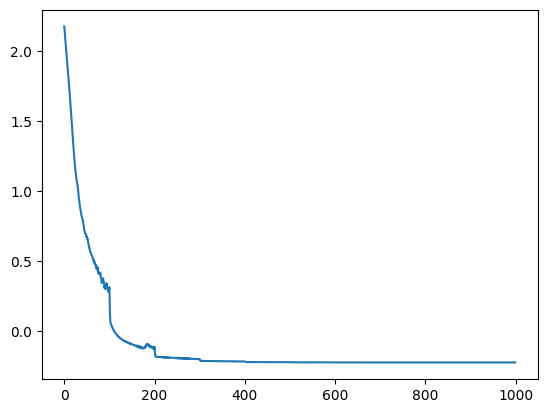

In [197]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

loss_fn(out_1, train_y1.reshape(-1,1))
loss_fn(out_2, train_y2.reshape(-1,1))
loss_fn(out_3, train_y3.reshape(-1,1))

In [198]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.4801e-01, -1.3326e-01, -2.0005e-01, -1.1470e-01, -1.9373e-01,
         -1.3920e-01, -1.8725e-01, -1.0721e-01,  1.6176e-01,  2.1190e-01,
          2.2610e-06, -1.4468e-06, -2.2117e-06,  1.1626e-06, -1.9504e-07,
          2.4931e-06,  1.9108e-06,  1.2119e-06,  3.1017e-06, -1.3967e-06,
         -6.4451e-07,  3.1674e-07,  6.7703e-07, -2.6741e-04, -3.3013e-06,
          2.6202e-06, -1.6921e-06, -2.7982e-06, -3.6071e-06, -8.4217e-07,
          2.7490e-06,  2.3233e-06,  2.1052e-03, -2.1170e-06,  2.1586e-06,
          2.0297e-06, -2.6034e-06, -2.6409e-06, -3.5549e-06,  2.1818e-06,
          2.2909e-06, -1.8223e-06, -3.1071e-06,  5.3869e-07,  3.1514e-06,
          2.7624e-06,  6.4581e-08, -3.1494e-06,  3.1458e-06, -2.7141e-06,
         -2.8011e-06,  3.0075e-06, -3.0567e-06,  2.1159e-07, -1.3077e-06,
         -1.0440e-06, -4.9513e-07,  1.5160e-06, -2.3787e-06,  9.4027e-07,
          8.6595e-07, -3.1986e-06, -2.1873e-02, -3.7015e-06, -9.5473e-07,
         -2.8160e-06,  3.4597e-06,  3.

tensor([[-1.4801e-01, -1.3326e-01, -2.0005e-01, -1.1470e-01, -1.9373e-01,
         -1.3920e-01, -1.8725e-01, -1.0721e-01,  1.6176e-01,  2.1190e-01,
          2.2610e-06, -1.4468e-06, -2.2117e-06,  1.1626e-06, -1.9504e-07,
          2.4931e-06,  1.9108e-06,  1.2119e-06,  3.1017e-06, -1.3967e-06,
         -6.4451e-07,  3.1674e-07,  6.7703e-07, -2.6741e-04, -3.3013e-06,
          2.6202e-06, -1.6921e-06, -2.7982e-06, -3.6071e-06, -8.4217e-07,
          2.7490e-06,  2.3233e-06,  2.1052e-03, -2.1170e-06,  2.1586e-06,
          2.0297e-06, -2.6034e-06, -2.6409e-06, -3.5549e-06,  2.1818e-06,
          2.2909e-06, -1.8223e-06, -3.1071e-06,  5.3869e-07,  3.1514e-06,
          2.7624e-06,  6.4581e-08, -3.1494e-06,  3.1458e-06, -2.7141e-06,
         -2.8011e-06,  3.0075e-06, -3.0567e-06,  2.1159e-07, -1.3077e-06,
         -1.0440e-06, -4.9513e-07,  1.5160e-06, -2.3787e-06,  9.4027e-07,
          8.6595e-07, -3.1986e-06, -2.1873e-02, -3.7015e-06, -9.5473e-07,
         -2.8160e-06,  3.4597e-06,  3.

tensor([[-1.9023e-01, -1.7544e-01, -2.3348e-01, -1.5082e-01,  2.1665e-01,
         -1.6171e-01, -2.6575e-01, -1.4486e-01, -2.2888e-01, -2.6786e-01,
         -2.5520e-07,  5.2882e-11,  8.9657e-08,  1.7722e-06,  1.5579e-08,
         -6.6401e-08,  1.0318e-08,  2.1422e-07,  1.2778e-07, -1.1858e-07,
          5.5211e-08, -1.5344e-08, -9.6488e-09,  1.9659e-02,  7.2516e-07,
         -7.8128e-09, -3.6889e-07,  1.5961e-08,  1.5726e-07, -8.2426e-08,
         -6.1728e-09, -7.9064e-09,  9.0369e-03, -5.3355e-08,  1.7193e-08,
         -1.5551e-07,  4.9523e-08,  1.0525e-09, -6.8394e-07, -1.4650e-07,
          1.1279e-07,  1.7516e-08, -7.5964e-09, -8.6648e-10, -8.6060e-08,
          1.3604e-08, -9.6060e-09, -2.6985e-08, -5.4565e-08, -9.9094e-07,
          5.8768e-10, -1.3183e-08, -1.2933e-08,  5.9266e-08,  3.9643e-08,
          3.9721e-07,  2.7084e-09, -3.1361e-09, -2.8068e-09, -3.1057e-07,
         -2.0979e-06,  1.2235e-08, -1.5684e-02,  3.4382e-07, -1.3244e-07,
          9.3437e-08, -1.2339e-07, -3.

In [199]:

model_1(test_x1)[0].squeeze()
test_y1.squeeze()
model_2(test_x2)[0].squeeze()
test_y2.squeeze()
model_3(test_x3)[0].squeeze()
test_y3.squeeze()


tensor([9.8708e-01, 2.1884e-01, 1.7930e-02, 9.8432e-01, 9.4638e-01, 9.9059e-01,
        9.7813e-01, 1.0819e-04, 9.2269e-01, 9.9066e-01, 1.1332e-02, 8.7467e-01,
        7.0544e-01, 5.8530e-01, 1.6167e-02, 4.2036e-02, 7.7643e-01, 1.0422e-01,
        9.8887e-01, 9.1608e-01, 2.6624e-01, 9.8489e-01, 7.8432e-01, 9.8658e-01,
        1.2001e-01, 9.7678e-01, 1.1919e-01, 2.2563e-01, 8.6145e-01, 1.4414e-02,
        6.5888e-01, 5.6628e-04, 8.0962e-04, 9.1790e-03, 1.9111e-01, 2.5538e-01,
        4.1788e-01, 9.7829e-01, 2.4518e-02, 5.0758e-01],
       grad_fn=<SqueezeBackward0>)

tensor([1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
        1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0.])

tensor([9.3952e-02, 8.6485e-01, 1.8261e-02, 1.0064e-01, 1.2096e-02, 8.6703e-02,
        1.1031e-02, 9.9467e-01, 4.1336e-02, 5.8788e-01, 6.0340e-01, 6.3549e-02,
        3.2416e-04, 9.9646e-01, 9.9739e-01, 2.1610e-03, 9.9214e-01, 3.3530e-01,
        6.5397e-02, 9.2234e-01, 5.9650e-01, 9.5919e-01, 2.4486e-04, 9.6886e-01,
        3.6489e-02, 4.9217e-02, 6.7102e-04, 5.0923e-02, 1.2377e-03, 9.9684e-01,
        8.6413e-01, 2.2407e-03, 1.9102e-01, 7.0905e-02, 6.2049e-04, 9.9690e-01,
        5.1289e-01, 9.4780e-01, 9.9435e-01, 9.4179e-01],
       grad_fn=<SqueezeBackward0>)

tensor([0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
        1., 1., 1., 1.])

tensor([9.6970e-01, 9.8451e-01, 3.1088e-01, 9.7837e-01, 1.2435e-01, 9.2371e-01,
        3.0319e-01, 5.2540e-01, 9.8510e-01, 6.5500e-02, 8.9504e-01, 1.6270e-04,
        9.9091e-01, 6.0096e-04, 9.7339e-01, 1.9298e-03, 9.8469e-01, 9.9212e-01,
        5.4927e-01, 9.4367e-01, 9.8560e-01, 2.4857e-02, 8.4889e-01, 3.4455e-03,
        2.0695e-02, 1.7062e-01, 9.9123e-01, 9.9519e-01, 9.8390e-01, 4.1051e-01,
        7.7398e-01, 1.6271e-01, 1.0126e-01, 2.8765e-01, 5.2457e-02, 7.2940e-03,
        2.6001e-02, 6.3842e-01, 1.3033e-02, 7.8071e-01],
       grad_fn=<SqueezeBackward0>)

tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.])

In [200]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[55,  8],
       [ 5, 52]])

0.9122807017543859

0.873015873015873

0.8916666666666667

0.8666666666666667

0.8888888888888888

In [201]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[19,  3],
       [ 0, 18]])

1.0

0.8636363636363636

array([[17,  3],
       [ 5, 15]])

0.75

0.85

array([[19,  2],
       [ 0, 19]])

1.0

0.9047619047619048

In [202]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_2_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_3_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.4800940e-01, -1.3326448e-01, -2.0004629e-01, -1.1469971e-01,
        -1.9373316e-01, -1.3920383e-01, -1.8724588e-01, -1.0721147e-01,
         1.6176255e-01,  2.1190464e-01,  2.2609775e-06, -1.4467604e-06,
        -2.2117076e-06,  1.1625665e-06, -1.9503977e-07,  2.4930546e-06,
         1.9107931e-06,  1.2118586e-06,  3.1016968e-06, -1.3966556e-06,
        -6.4450705e-07,  3.1674344e-07,  6.7702985e-07, -2.6741053e-04,
        -3.3013052e-06,  2.6202354e-06, -1.6920732e-06, -2.7982221e-06,
        -3.6071262e-06, -8.4217328e-07,  2.7489630e-06,  2.3233092e-06,
         2.1052146e-03, -2.1169624e-06,  2.1585945e-06,  2.0296532e-06,
        -2.6033902e-06, -2.6408886e-06, -3.5549142e-06,  2.1818387e-06,
         2.2909310e-06, -1.8222991e-06, -3.1071020e-06,  5.3868860e-07,
         3.1513841e-06,  2.7623657e-06,  6.4581108e-08, -3.1494130e-06,
         3.1457907e-06, -2.7140848e-06, -2.8011059e-06,  3.0074755e-06,
        -3.0566514e-06,  2.1158948e-07, -1.3076913e-06, -1.04399

array([[-1.4800940e-01, -1.3326448e-01, -2.0004629e-01, -1.1469971e-01,
        -1.9373316e-01, -1.3920383e-01, -1.8724588e-01, -1.0721147e-01,
         1.6176255e-01,  2.1190464e-01,  2.2609775e-06, -1.4467604e-06,
        -2.2117076e-06,  1.1625665e-06, -1.9503977e-07,  2.4930546e-06,
         1.9107931e-06,  1.2118586e-06,  3.1016968e-06, -1.3966556e-06,
        -6.4450705e-07,  3.1674344e-07,  6.7702985e-07, -2.6741053e-04,
        -3.3013052e-06,  2.6202354e-06, -1.6920732e-06, -2.7982221e-06,
        -3.6071262e-06, -8.4217328e-07,  2.7489630e-06,  2.3233092e-06,
         2.1052146e-03, -2.1169624e-06,  2.1585945e-06,  2.0296532e-06,
        -2.6033902e-06, -2.6408886e-06, -3.5549142e-06,  2.1818387e-06,
         2.2909310e-06, -1.8222991e-06, -3.1071020e-06,  5.3868860e-07,
         3.1513841e-06,  2.7623657e-06,  6.4581108e-08, -3.1494130e-06,
         3.1457907e-06, -2.7140848e-06, -2.8011059e-06,  3.0074755e-06,
        -3.0566514e-06,  2.1158948e-07, -1.3076913e-06, -1.04399

array([[-1.90234050e-01, -1.75439030e-01, -2.33478859e-01,
        -1.50818124e-01,  2.16653138e-01, -1.61714524e-01,
        -2.65752196e-01, -1.44859299e-01, -2.28881523e-01,
        -2.67859578e-01, -2.55203958e-07,  5.28817927e-11,
         8.96568295e-08,  1.77218533e-06,  1.55788786e-08,
        -6.64005455e-08,  1.03180602e-08,  2.14222823e-07,
         1.27780183e-07, -1.18579614e-07,  5.52106627e-08,
        -1.53441473e-08, -9.64883995e-09,  1.96585823e-02,
         7.25163545e-07, -7.81279574e-09, -3.68888664e-07,
         1.59607723e-08,  1.57264211e-07, -8.24257143e-08,
        -6.17281781e-09, -7.90637777e-09,  9.03687254e-03,
        -5.33553752e-08,  1.71931589e-08, -1.55512410e-07,
         4.95230204e-08,  1.05246045e-09, -6.83936889e-07,
        -1.46497513e-07,  1.12788122e-07,  1.75157897e-08,
        -7.59637508e-09, -8.66477612e-10, -8.60601475e-08,
         1.36044473e-08, -9.60597646e-09, -2.69854148e-08,
        -5.45645626e-08, -9.90943818e-07,  5.87684901e-1

In [204]:
threshold=0.12
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.1480094 , -0.13326448, -0.20004629, -0.11469971, -0.19373316,
        -0.13920383, -0.18724588, -0.10721147,  0.16176255,  0.21190464,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

10